In [1]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method 
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.torch.attacks.noise import noise 
from cleverhans.torch.attacks.hop_skip_jump_attack import hop_skip_jump_attack 
from cleverhans.torch.attacks.spsa import spsa 
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2 
from cleverhans.torch.attacks.sparse_l1_descent import sparse_l1_descent 


In [2]:
from models import *
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
import seaborn as sn
import pandas as pd


from absl import app, flags
from easydict import EasyDict
import torch.nn as nn

%matplotlib inline

import seaborn as sns

from custom_transform import *
from transforms import TRANSFORMS
from mask import *
import imageio
from utils import generate_gif
import os


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
   
  
])


epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000
use_cuda = torch.cuda.is_available()
print(use_cuda)

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}

test_kwargs = {'batch_size': test_batch_size}
stable_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)
    
    
#init stuffs
# LOAD = True
# LOADPATH = 'FFN19-17-24'
LOADPATH = 'FFN18_28_21'
# LOADPATH = 'TinyCNN14-28-29'

LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('./data', train=True, download=False,
                          transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=False,
                          transform=transform)



modification_string = ""
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
model.load_state_dict(torch.load(LOADPATH))


True


<All keys matched successfully>

In [4]:
MIX_GIF_FOLDER = "./mix_gif/"
GIF_RESULT = "mix{}-{}.gif"
TMP_MIX_IMG_FOLDER = "./tmp_mix"
MIX_GRAPH = "./mix_graph"

# Check image mixing: two same class images

Two same class images from class 5 we found: [23, 45]


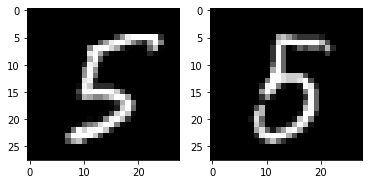

In [5]:
# Find two images from the same class

same_class = 5
two_same_image = []

for img_idx in range(16, 120):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    if label == same_class:
        two_same_image.append(img_idx)
    if len(two_same_image) == 2:
        break
        
assert len(two_same_image) == 2, "Need 2 samples!"
        
print(f"Two same class images from class {same_class} we found: {two_same_image}")

two_same_cls_imgs = torch.utils.data.Subset(dataset2, two_same_image)
(same_cls_img1, same_cls_label1) =  two_same_cls_imgs[0]
(same_cls_img2, same_cls_label2) =  two_same_cls_imgs[1]

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(same_cls_img1.reshape(28, 28), cmap="gray")
axarr[1].imshow(same_cls_img2.reshape(28, 28), cmap="gray")





In [6]:
# #Sample the alpha values, and draw the mixed images

# num_sample = 10
# # alps = np.random.uniform(low=0.0, high=1.0, size=num_sample)
# alps = np.linspace(0, 1, num_sample)
# alps = np.sort(alps) 
# print("alphas picked: ", alps)


# MIX_GIF_FOLDER = "./mix_gif/"
# GIF_RESULT = "mix{}-{}.gif"
# TMP_MIX_IMG_FOLDER = "./tmp_mix"
# if not os.path.exists(TMP_MIX_IMG_FOLDER):
#     os.mkdir(TMP_MIX_IMG_FOLDER)
# if not os.path.exists(MIX_GIF_FOLDER):
#     os.mkdir(MIX_GIF_FOLDER)

# mixed_img_names = []
# mixed_img_cls_prod = []


# for i in range(len(alps)):
#     a = alps[i]
#     mixed_img = (1-a)*same_cls_img1 + a*same_cls_img2
#     print(mixed_img.size())
#     mixed_img_extend = mixed_img[None, :]
    
#     # make the prediction
#     with torch.no_grad():
#         output = model(mixed_img_extend.to(device))
#     cls_prob =  torch.softmax(output, dim=1)[:, same_class].item()
#     pred_prob = torch.max(torch.softmax(output, dim=1)).item()
#     pred = torch.argmax(output).item()
#     mixed_img_cls_prod.append(cls_prob)
    
#     figure = plt.figure()
#     plt.imshow(mixed_img.reshape(28, 28), cmap="gray")
#     plt.title(f"pred: {pred}, prob: {pred_prob}")
#     mix_img_name = f"mix{two_same_image[0]}-{two_same_image[1]}_{i}.png"
#     mixed_img_names.append(mix_img_name)
#     plt.savefig(os.path.join(TMP_MIX_IMG_FOLDER, mix_img_name))
    
        

# # generate gif
# generate_gif(os.path.join(MIX_GIF_FOLDER, GIF_RESULT.format(two_same_image[0], two_same_image[1])), TMP_MIX_IMG_FOLDER, mixed_img_names, True)




In [7]:
# # plotting the points 
# plt.plot(alps, mixed_img_cls_prod)
# plt.plot(alps, [0]*10, label = "line 2")
# # naming the x axis
# plt.xlabel('x - axis')
# # naming the y axis
# plt.ylabel('y - axis')
  
# # giving a title to my graph
# plt.title('My first graph!')
  
# # function to show the plot
# plt.show()

alphas picked:  [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
tensor([0.0298, 0.0288, 0.0279, 0.0270, 0.0261, 0.0253, 0.0241, 0.0229, 0.0218,
        0.0207, 0.0198, 0.0189, 0.0182, 0.0174, 0.0167, 0.0161, 0.0156, 0.0152,
        0.0148, 0.0145], device='cuda:0')


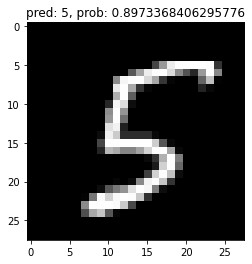

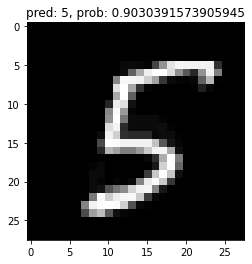

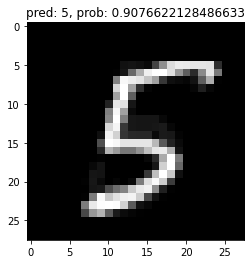

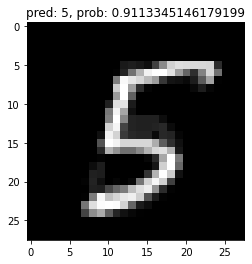

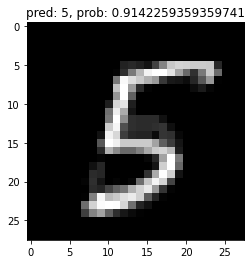

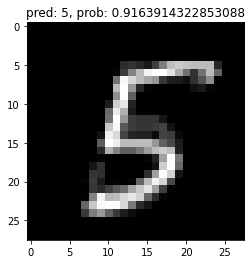

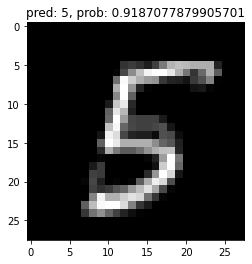

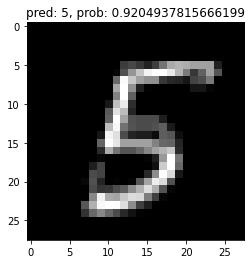

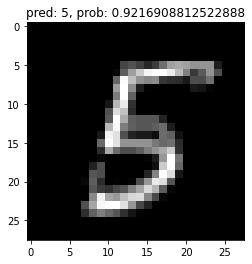

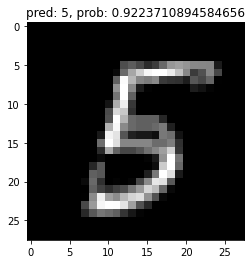

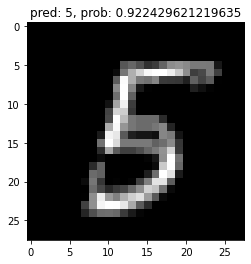

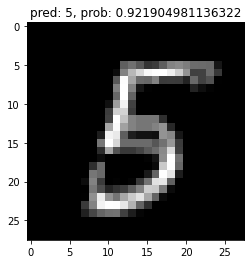

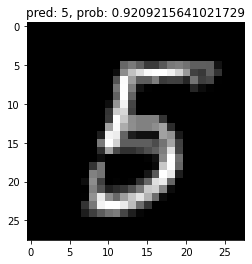

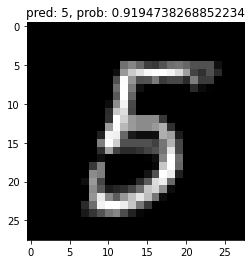

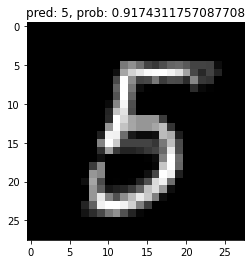

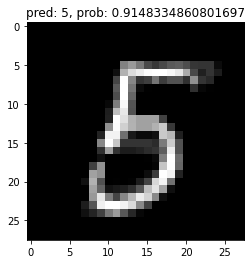

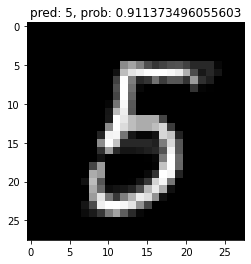

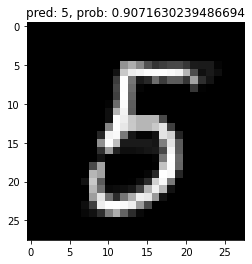

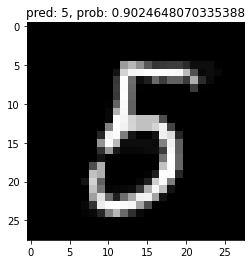

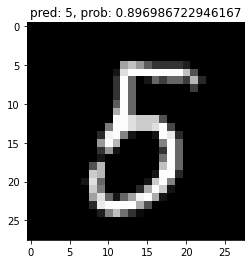

In [9]:
#Sample the alpha values, and draw the mixed images

num_sample = 20
# alps = np.random.uniform(low=0.0, high=1.0, size=num_sample)
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
print("alphas picked: ", alps)


# MIX_GIF_FOLDER = "./mix_gif/"
# GIF_RESULT = "mix{}-{}.gif"
# TMP_MIX_IMG_FOLDER = "./tmp_mix"
# MIX_GRAPH = "./mix_graph"
if not os.path.exists(TMP_MIX_IMG_FOLDER):
    os.mkdir(TMP_MIX_IMG_FOLDER)
if not os.path.exists(MIX_GIF_FOLDER):
    os.mkdir(MIX_GIF_FOLDER)

mixed_img_names = []
# mixed_img_cls_prod = []
all_mixed_imgs = []
all_cls_probs = []

for i in range(len(alps)):
    a = alps[i]
    mixed_img = (1-a)*same_cls_img1 + a*same_cls_img2
#     print(mixed_img.size())
    mixed_img_extend = mixed_img[None, :]
    
    
    # make the prediction
    with torch.no_grad():
        output = model(mixed_img_extend.to(device))
    prob_output =  torch.softmax(output, dim=1)
    all_cls_probs.append(prob_output)
    pred_prob = torch.max(prob_output)
    pred = torch.argmax(output).item()
    
    
    figure = plt.figure()
    plt.imshow(mixed_img.reshape(28, 28), cmap="gray")
    plt.title(f"pred: {pred}, prob: {pred_prob}")
    mix_img_name = f"mix{two_same_image[0]}-{two_same_image[1]}_{i}.png"
    mixed_img_names.append(mix_img_name)
    plt.savefig(os.path.join(TMP_MIX_IMG_FOLDER, mix_img_name))
    

all_cls_probs_tensor = torch.cat(all_cls_probs)  
print(all_cls_probs_tensor[:, 0])
    

# generate gif
generate_gif(os.path.join(MIX_GIF_FOLDER, GIF_RESULT.format(two_same_image[0], two_same_image[1])), TMP_MIX_IMG_FOLDER, mixed_img_names, True)





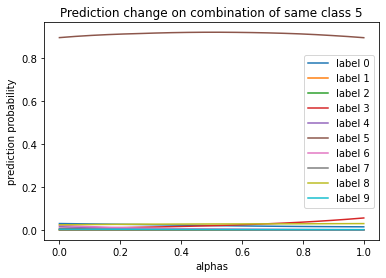

In [10]:
# all_cls_probs_tensor.cpu()
for c in range(10):
    # plotting the points 
    plt.plot(alps, all_cls_probs_tensor.cpu()[:, c], label=f"label {c}")
# naming the x axis
plt.xlabel('alphas')
# naming the y axis
plt.ylabel('prediction probability')

# giving a title to my graph
plt.title(f'Prediction change on combination of same class {same_class}')
plt.legend()
# function to show the plot
graph_name =  f"graphmix{two_same_image[0]}-{two_same_image[1]}.png"
plt.savefig(os.path.join(MIX_GRAPH, graph_name))
plt.show()

# Check image mixing: two different class images

Two same class images from class 5 we found: [23, 45]


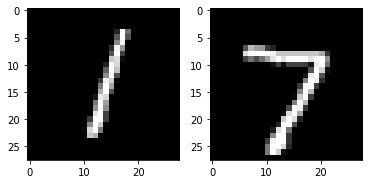

In [11]:
# Find two images from the same class

diff_class = {1: None, 7: None}

for img_idx in range(0, 120):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    if label in list(diff_class.keys()) and diff_class[label] is None:
        diff_class[label]= img_idx
    if None not in list(diff_class.values()):
        break
        
assert len(diff_class) == 2, "Need 2 samples!"
        
print(f"Two same class images from class {same_class} we found: {two_same_image}")

two_diff_cls_imgs = torch.utils.data.Subset(dataset2, list(diff_class.values()))
(diff_cls_img1, diff_cls_label1) =  two_diff_cls_imgs[0]
(diff_cls_img2, diff_cls_label2) =  two_diff_cls_imgs[1]

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(diff_cls_img1.reshape(28, 28), cmap="gray")
axarr[1].imshow(diff_cls_img2.reshape(28, 28), cmap="gray")

alphas picked:  [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
tensor([4.4890e-05, 7.7771e-05, 1.5589e-04, 3.3044e-04, 6.4336e-04, 1.0096e-03,
        1.2187e-03, 1.2005e-03, 1.0769e-03, 9.2581e-04, 7.7837e-04, 6.7807e-04,
        6.1081e-04, 5.5808e-04, 5.1118e-04, 4.6438e-04, 4.1783e-04, 3.7368e-04,
        3.3446e-04, 2.9963e-04], device='cuda:0')


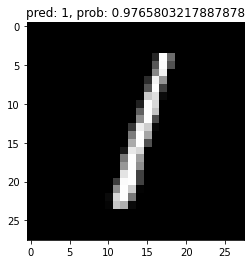

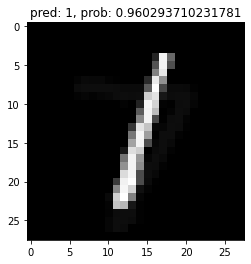

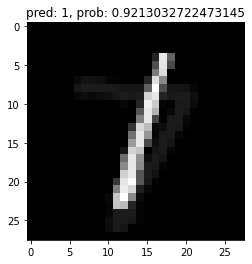

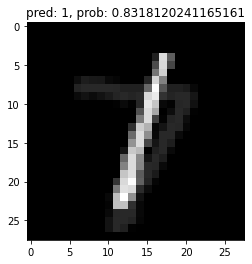

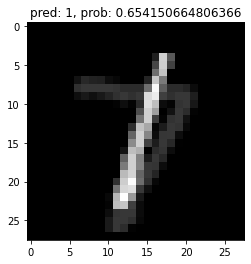

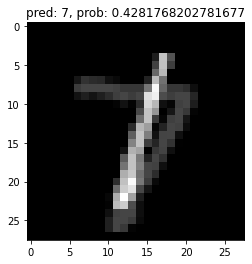

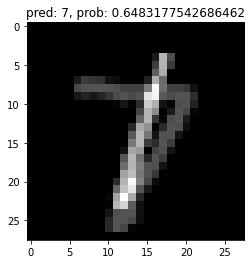

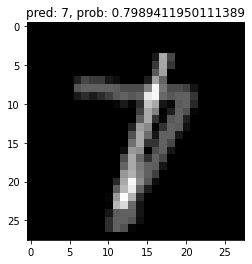

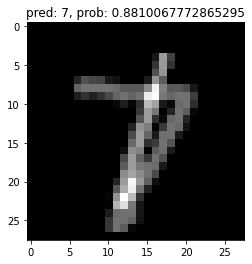

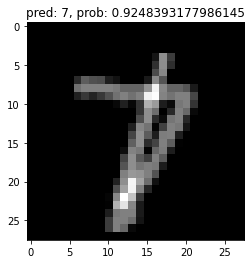

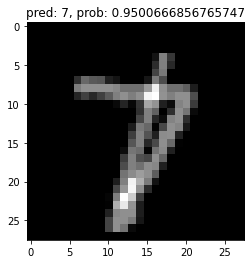

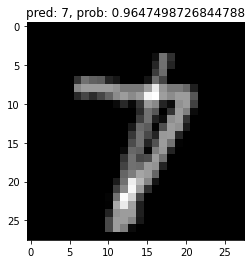

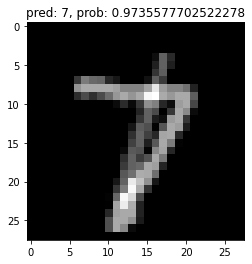

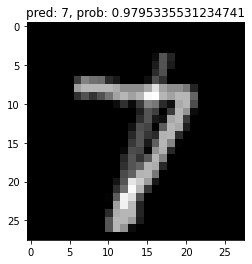

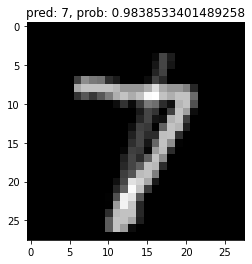

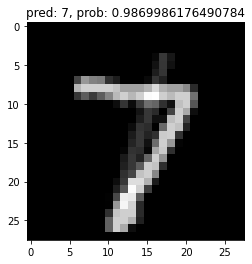

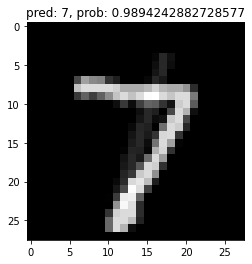

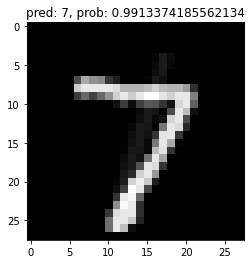

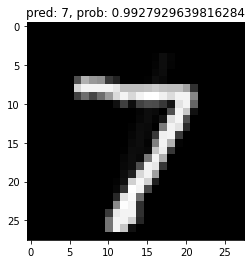

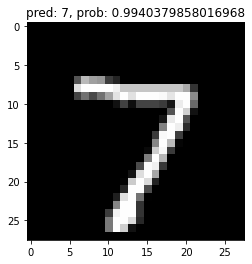

In [12]:
#Sample the alpha values, and draw the mixed images

num_sample = 20
# alps = np.random.uniform(low=0.0, high=1.0, size=num_sample)
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
print("alphas picked: ", alps)


# MIX_GIF_FOLDER = "./mix_gif/"
# GIF_RESULT = "mix{}-{}.gif"
# TMP_MIX_IMG_FOLDER = "./tmp_mix"
if not os.path.exists(TMP_MIX_IMG_FOLDER):
    os.mkdir(TMP_MIX_IMG_FOLDER)
if not os.path.exists(MIX_GIF_FOLDER):
    os.mkdir(MIX_GIF_FOLDER)

mixed_img_names = []
# mixed_img_cls_prod = []
all_mixed_imgs = []
all_cls_probs = []

for i in range(len(alps)):
    a = alps[i]
    mixed_img = (1-a)*diff_cls_img1 + a*diff_cls_img2
#     print(mixed_img.size())
    mixed_img_extend = mixed_img[None, :]
    
    
    # make the prediction
    with torch.no_grad():
        output = model(mixed_img_extend.to(device))
    prob_output =  torch.softmax(output, dim=1)
    all_cls_probs.append(prob_output)
    pred_prob = torch.max(prob_output)
    pred = torch.argmax(output).item()
    
    
    figure = plt.figure()
    plt.imshow(mixed_img.reshape(28, 28), cmap="gray")
    plt.title(f"pred: {pred}, prob: {pred_prob}")
    mix_img_name = f"mix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}_{i}.png"
    mixed_img_names.append(mix_img_name)
    plt.savefig(os.path.join(TMP_MIX_IMG_FOLDER, mix_img_name))
    

all_cls_probs_tensor = torch.cat(all_cls_probs)  
print(all_cls_probs_tensor[:, 0])
    

# generate gif
generate_gif(os.path.join(MIX_GIF_FOLDER, GIF_RESULT.format(list(diff_class.values())[0], list(diff_class.values())[1])), TMP_MIX_IMG_FOLDER, mixed_img_names, True)





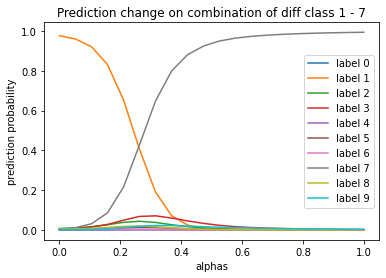

In [13]:
# all_cls_probs_tensor.cpu()
for c in range(10):
    # plotting the points 
    plt.plot(alps, all_cls_probs_tensor.cpu()[:, c], label=f"label {c}")
# naming the x axis
plt.xlabel('alphas')
# naming the y axis
plt.ylabel('prediction probability')

# giving a title to my graph
plt.title(f'Prediction change on combination of diff class {list(diff_class.keys())[0]} - {list(diff_class.keys())[1]}')
plt.legend()
# function to show the plot
graph_name = f"graphmix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}.png"
plt.savefig(os.path.join(MIX_GRAPH, graph_name))
plt.show()

# Check image mixing: All black -> some Image

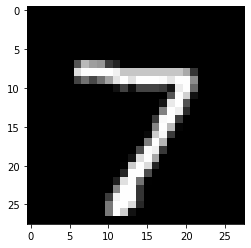

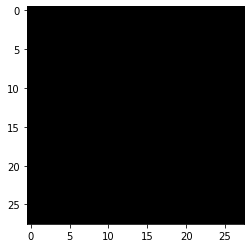

In [14]:
(img, label) = torch.utils.data.Subset(dataset2, [0])[0]


new = img * 0


figure = plt.figure()
plt.imshow(img.reshape(28, 28), cmap="gray")

figure = plt.figure()
plt.imshow(new.reshape(28, 28), cmap="gray")


(diff_cls_img1, diff_cls_label1) =  new, label
(diff_cls_img2, diff_cls_label2) =  img, label

alphas picked:  [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
a is 0.0
max:  torch.return_types.max(
values=tensor(-0.),
indices=tensor(0))

min:  torch.return_types.min(
values=tensor(-0.),
indices=tensor(0))

mean:  tensor(0.)

a is 0.05263157894736842
max:  torch.return_types.max(
values=tensor(0.1485),
indices=tensor(355))

min:  torch.return_types.min(
values=tensor(-0.0223),
indices=tensor(0))

mean:  tensor(-0.0066)

a is 0.10526315789473684
max:  torch.return_types.max(
values=tensor(0.2970),
indices=tensor(355))

min:  torch.return_types.min(
values=tensor(-0.0447),
indices=tensor(0))

mean:  tensor(-0.0131)

a is 0.15789473684210525
max:  torch.return_types.max(
values=tensor(0.4455),
indices=tensor(355))

min:  torch.return_types.min(
values=tensor(-0.0670),
indices=tensor(0))

mean:  tensor(-0.0197

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_27492\1801456939.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


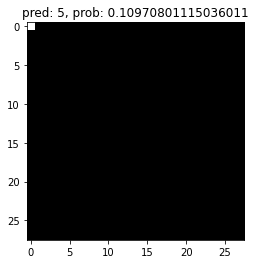

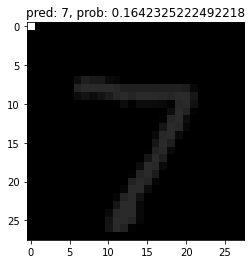

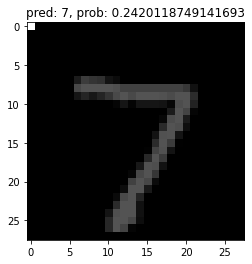

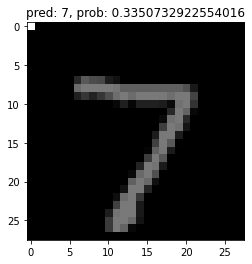

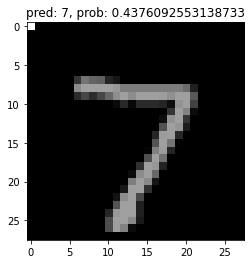

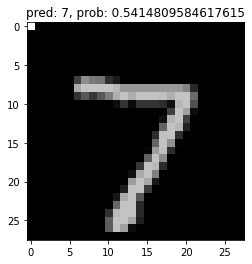

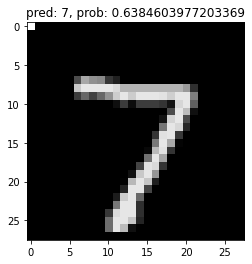

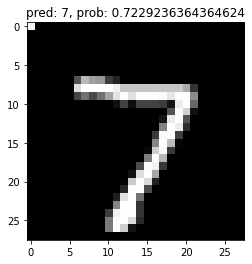

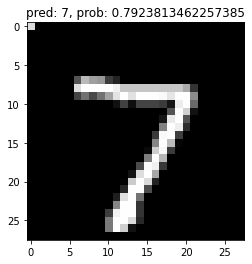

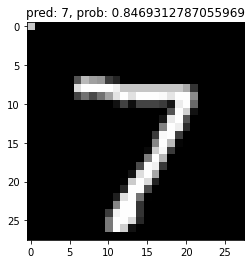

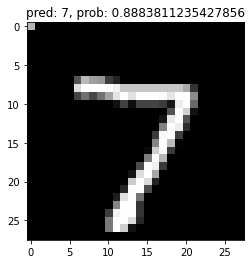

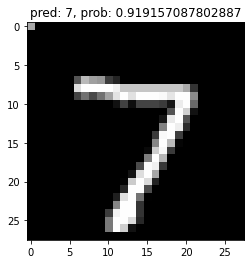

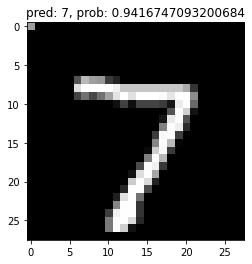

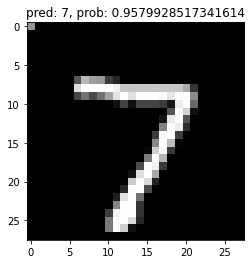

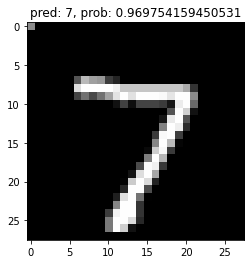

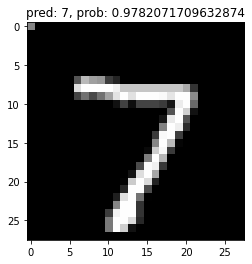

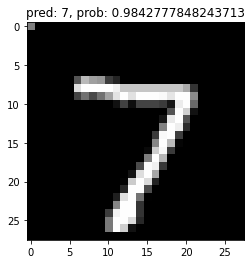

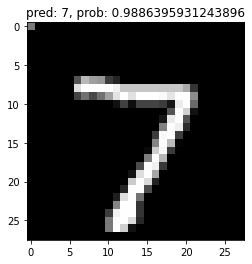

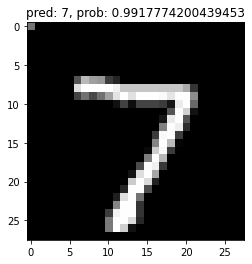

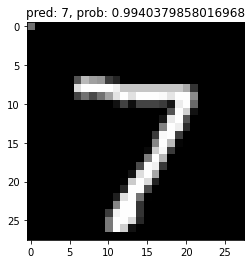

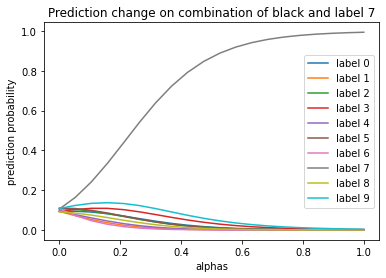

In [15]:
#Sample the alpha values, and draw the mixed images

num_sample = 20
# alps = np.random.uniform(low=0.0, high=1.0, size=num_sample)
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
print("alphas picked: ", alps)


# MIX_GIF_FOLDER = "./mix_gif/"
# GIF_RESULT = "mix{}-{}.gif"
# TMP_MIX_IMG_FOLDER = "./tmp_mix"
if not os.path.exists(TMP_MIX_IMG_FOLDER):
    os.mkdir(TMP_MIX_IMG_FOLDER)
if not os.path.exists(MIX_GIF_FOLDER):
    os.mkdir(MIX_GIF_FOLDER)

mixed_img_names = []
# mixed_img_cls_prod = []
all_mixed_imgs = []
all_cls_probs = []

for i in range(len(alps)):
    a = alps[i]
    mixed_img = (1-a)*diff_cls_img1 + a*diff_cls_img2
#     print("image value: ", mixed_img)
    print(f"a is {a}")
    print("max: ", torch.max(mixed_img.reshape(28* 28), axis = 0))
    print()
    print("min: ", torch.min(mixed_img.reshape(28* 28), axis = 0))
    print()
    print("mean: ", torch.mean(mixed_img.reshape(28* 28), axis = 0))
    print()
#     print("max: ", np.max(mixed_img, axis = 0))
#     print(mixed_img.size())
    mixed_img_extend = mixed_img[None, :]
    
    
    # make the prediction
    with torch.no_grad():
        output = model(mixed_img_extend.to(device))
    prob_output =  torch.softmax(output, dim=1)
    all_cls_probs.append(prob_output)
    pred_prob = torch.max(prob_output)
    pred = torch.argmax(output).item()
    
    
    figure = plt.figure()
    mixed_img[..., 0, 0] = 1.0 
    plt.imshow(mixed_img.reshape(28, 28), cmap="gray")
    plt.title(f"pred: {pred}, prob: {pred_prob}")
#     mix_img_name = f"mix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}_{i}.png"
#     mixed_img_names.append(mix_img_name)
#     plt.savefig(os.path.join(TMP_MIX_IMG_FOLDER, mix_img_name))
    

all_cls_probs_tensor = torch.cat(all_cls_probs)  
print(all_cls_probs_tensor[:, 0])
    

# generate gif
# generate_gif(os.path.join(MIX_GIF_FOLDER, GIF_RESULT.format(list(diff_class.values())[0], list(diff_class.values())[1])), TMP_MIX_IMG_FOLDER, mixed_img_names, True)

# all_cls_probs_tensor.cpu()
figure = plt.figure()
for c in range(10):
    # plotting the points 
    plt.plot(alps, all_cls_probs_tensor.cpu()[:, c], label=f"label {c}")
# naming the x axis
plt.xlabel('alphas')
# naming the y axis
plt.ylabel('prediction probability')

# giving a title to my graph
plt.title(f'Prediction change on combination of black and label {label}')
plt.legend()
# function to show the plot
# graph_name = f"graphmix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}.png"
# plt.savefig(os.path.join(MIX_GRAPH, graph_name))
plt.show()

find adversial example: 50 with label 6 and attack pred tensor([0], device='cuda:0')


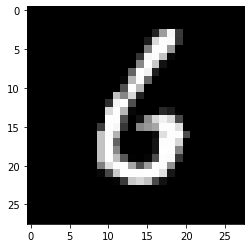

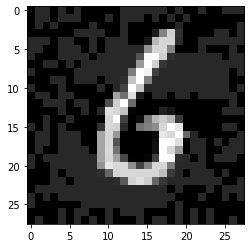

In [16]:
for img_idx in range(50, 100):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]



    x_extend = img[None, :]

    x_extend = x_extend.to(device)
    x_fgm = fast_gradient_method(model, x_extend, 0.3, np.inf)
    _, y_pred_fgm = model(x_fgm).max(
                1
            )
    if y_pred_fgm != label:
        print(f"find adversial example: {img_idx} with label {label} and attack pred {y_pred_fgm}")
        break


figure = plt.figure()
plt.imshow(img.cpu().detach().numpy().reshape(28, 28), cmap="gray")

figure = plt.figure()
plt.imshow(x_fgm.cpu().detach().numpy().reshape(28, 28), cmap="gray")


(diff_cls_img1, diff_cls_label1) =  x_extend*0, label
(diff_cls_img2, diff_cls_label2) =  x_fgm, label

alphas picked:  [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
a is 0.0
max:  torch.return_types.max(
values=tensor(-0., device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(0, device='cuda:0'))

min:  torch.return_types.min(
values=tensor(-0., device='cuda:0', grad_fn=<MinBackward0>),
indices=tensor(0, device='cuda:0'))

mean:  tensor(0., device='cuda:0', grad_fn=<MeanBackward1>)

check size: torch.Size([1, 1, 28, 28])
a is 0.05263157894736842
max:  torch.return_types.max(
values=tensor(0.1636, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(211, device='cuda:0'))

min:  torch.return_types.min(
values=tensor(-0.0381, device='cuda:0', grad_fn=<MinBackward0>),
indices=tensor(0, device='cuda:0'))

mean:  tensor(-0.0050, device='cuda:0', grad_fn=<MeanBackward1>)

check size: torch.Size([1, 1, 28, 28])

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_27492\2240792490.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


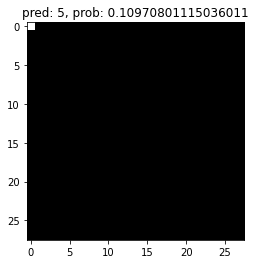

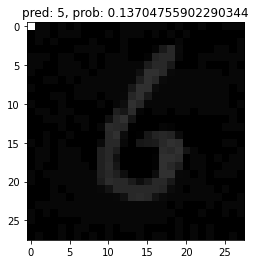

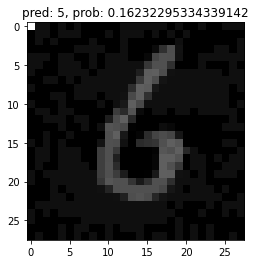

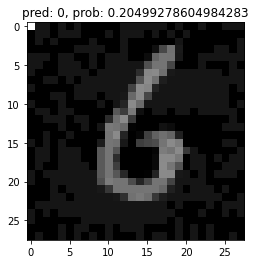

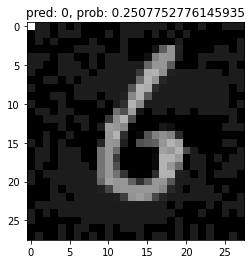

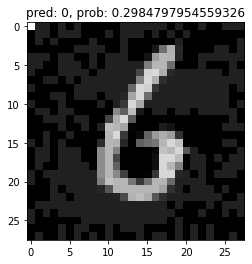

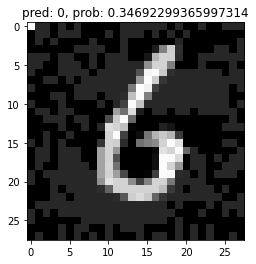

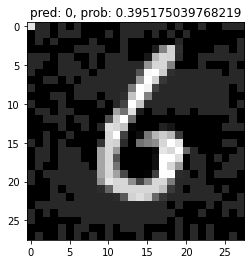

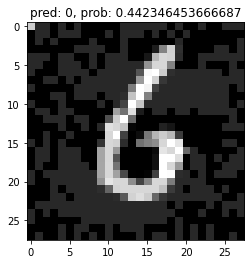

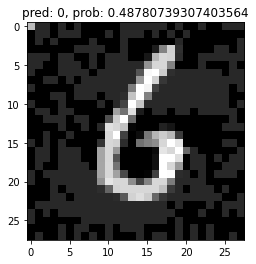

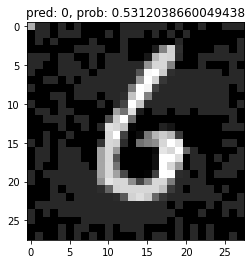

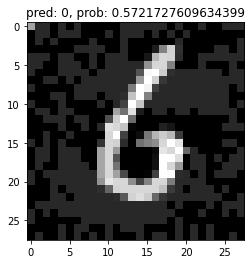

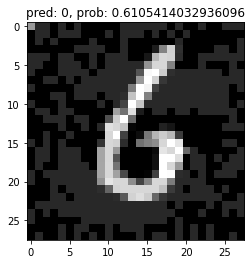

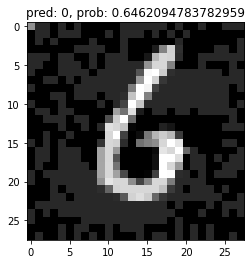

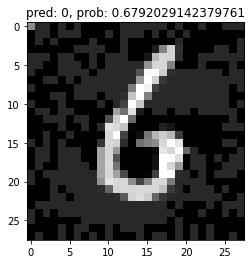

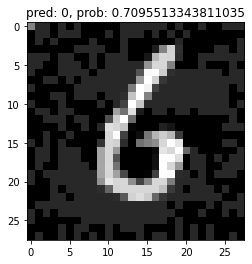

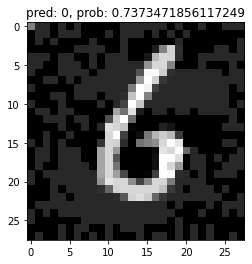

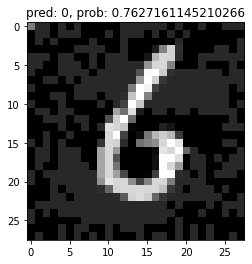

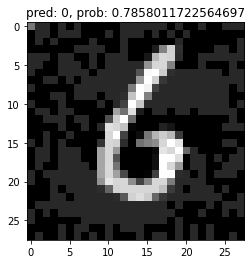

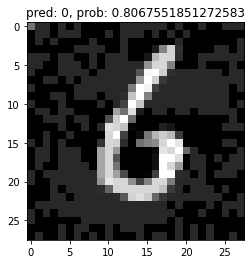

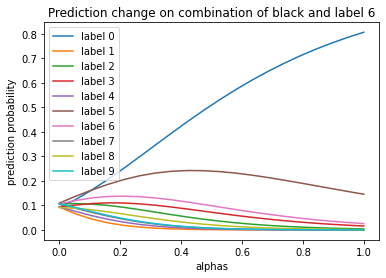

In [17]:
#Sample the alpha values, and draw the mixed images

num_sample = 20
# alps = np.random.uniform(low=0.0, high=1.0, size=num_sample)
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
print("alphas picked: ", alps)


# MIX_GIF_FOLDER = "./mix_gif/"
# GIF_RESULT = "mix{}-{}.gif"
# TMP_MIX_IMG_FOLDER = "./tmp_mix"
if not os.path.exists(TMP_MIX_IMG_FOLDER):
    os.mkdir(TMP_MIX_IMG_FOLDER)
if not os.path.exists(MIX_GIF_FOLDER):
    os.mkdir(MIX_GIF_FOLDER)

mixed_img_names = []
# mixed_img_cls_prod = []
all_mixed_imgs = []
all_cls_probs = []

for i in range(len(alps)):
    a = alps[i]
    mixed_img = (1-a)*diff_cls_img1 + a*diff_cls_img2
#     print("image value: ", mixed_img)
    print(f"a is {a}")
    print("max: ", torch.max(mixed_img.reshape(28* 28), axis = 0))
    print()
    print("min: ", torch.min(mixed_img.reshape(28* 28), axis = 0))
    print()
    print("mean: ", torch.mean(mixed_img.reshape(28* 28), axis = 0))
    print()
#     print("max: ", np.max(mixed_img, axis = 0))
    print("check size:", mixed_img.size())
    mixed_img_extend = mixed_img
    
    
    # make the prediction
    with torch.no_grad():
        output = model(mixed_img_extend.to(device))
    prob_output =  torch.softmax(output, dim=1)
    all_cls_probs.append(prob_output)
    pred_prob = torch.max(prob_output)
    pred = torch.argmax(output).item()
    
    
    figure = plt.figure()
    mixed_img[..., 0, 0] = 1.0 
    plt.imshow(mixed_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    plt.title(f"pred: {pred}, prob: {pred_prob}")
#     mix_img_name = f"mix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}_{i}.png"
#     mixed_img_names.append(mix_img_name)
#     plt.savefig(os.path.join(TMP_MIX_IMG_FOLDER, mix_img_name))
    

all_cls_probs_tensor = torch.cat(all_cls_probs)  
print(all_cls_probs_tensor[:, 0])
    

# generate gif
# generate_gif(os.path.join(MIX_GIF_FOLDER, GIF_RESULT.format(list(diff_class.values())[0], list(diff_class.values())[1])), TMP_MIX_IMG_FOLDER, mixed_img_names, True)

# all_cls_probs_tensor.cpu()
figure = plt.figure()
for c in range(10):
    # plotting the points 
    plt.plot(alps, all_cls_probs_tensor.cpu()[:, c], label=f"label {c}")
# naming the x axis
plt.xlabel('alphas')
# naming the y axis
plt.ylabel('prediction probability')

# giving a title to my graph
plt.title(f'Prediction change on combination of black and label {label}')
plt.legend()
# function to show the plot
# graph_name = f"graphmix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}.png"
# plt.savefig(os.path.join(MIX_GRAPH, graph_name))
plt.show()

# Check pattern overlap

In [10]:
layers = ['fc1', 'fc2', 'fc3', 'fc4']


In [31]:
# Check average overlap ratio on 100 random pairs
pair_num = 200

list1 = np.random.choice(range(10000), pair_num, replace=False)
list2 = np.random.choice(range(10000), pair_num, replace=False)

avg_pair_check_ratio = 0
for idx1, idx2 in zip(list1, list2):
    pair_imgs = torch.utils.data.Subset(dataset2, [idx1, idx2])
    (pair_img1, pair_target1) = pair_imgs[0]
    (pair_img2, pair_target2) = pair_imgs[1]
    
    pair_img1_extend = pair_img1[None, :]
    pair_img2_extend = pair_img2[None, :]
    
    pair_img1_pattern = model.get_pattern(pair_img1_extend, layers, device, flatten=True)
    pair_img2_pattern = model.get_pattern(pair_img2_extend, layers, device, flatten=True)
    
    pair_imgs_pattern_check = pair_img1_pattern == pair_img2_pattern
    
    pair_overlap_ratio = pair_imgs_pattern_check.sum() / len(pair_imgs_pattern_check[0])
#     print(f"Pattern overlap ratio for image {(idx1, idx2)} is {pair_overlap_ratio}")
    
    avg_pair_check_ratio += pair_overlap_ratio

    
avg_pair_check_ratio = avg_pair_check_ratio / pair_num

print(f"\nAverage pattern overlap ratio over {pair_num} random pairs {avg_pair_check_ratio}")


Average pattern overlap ratio over 200 random pairs 0.8022270742358079


In [46]:
num_sample = 20
# alps = np.random.uniform(low=0.0, high=1.0, size=num_sample)
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
# print("alphas picked: ", alps)

num_check = 200
img_idxes = np.random.choice(range(10000), num_check, replace=False)
check_set = torch.utils.data.Subset(dataset2, img_idxes)
print(f"indices of {num_check} images going to be checked: {img_idxes}")

thrd = 1
avg_alp_satified_thrd = 0

for (rdm_img, rdm_target) in check_set:

    rdm_img_extend = rdm_img[None, :]

    img_pattern = model.get_pattern(rdm_img_extend, layers, device, flatten=True)
    
    satify_thrd = False
    for i in range(len(alps)):
        a = alps[i]
        if a == 0:
            continue
        discounted_img = a*rdm_img_extend

        discounted_img_pattern = model.get_pattern(discounted_img, layers, device, flatten=True)
        pattern_check = img_pattern == discounted_img_pattern
        pattern_check_ratio = pattern_check.sum() / len(pattern_check[0])
        
        if pattern_check_ratio >= thrd and not satify_thrd:
            avg_alp_satified_thrd += a
            satify_thrd = True
    
        if num_check == 1:
            print("pattern check ratio:", pattern_check_ratio)
            print("number of neuron in difference:", len(pattern_check[0])-pattern_check.sum() )

avg_alp_satified_thrd = avg_alp_satified_thrd / num_check
print(f"\n Avg alpha for satisfying threshold: {avg_alp_satified_thrd}")

indices of 200 images going to be checked: [ 493 9700 1387 9769 1967 1686 9789 7030 5369 5861 5610 4882 2777 1769
 2229 9036 7427 7130 9837 6685 9103 6792 4030 7531 4132  362 7465  476
 5330 4242  465 3164 2351 8202 3223 5765 2332 7403 2549 6498 6262 1787
 9174 8373 1663 5622 5246 6847 6778 3934 7708 6041 9456 6765 2264 5899
 4546 3397 4700  895 6173 5198 1073 8253 6401 1741 3430 7950 5006 8288
 1066 8778 4956 9508 4733 8367 5215  654 9423 5845 3095 3035 2727 4876
 2843  990   47 8419 5777 3519 9090 4676 1228 2486   17 5629 4438 8893
  340 7873  748 5997  182 1109 9154 1870 4230 5742 5614 3680  409 8777
 4141 6849 9142 7929  444  918 9130  875 8923 8311 1647 8976 4641 2290
 5977 1567 7827 9440  293 1670 4109 7537 6933 7672 9946 9420 2599 8108
 7737 7134 9144 1432 1538 9535 3302 6160 8063  247 5281 8575 8992 5075
 5378 4117 7232 9249 2784 4560 6267 3826 5087 7040 2460 4964  352 2801
 1794   61 4320 9446 5585 6370 8994   94 5720 2387 6562 3501 1429 2137
 9450 5569 5413 7391 5120 3217 660

In [47]:
num_sample = 20
# alps = np.random.uniform(low=0.0, high=1.0, size=num_sample)
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
# print("alphas picked: ", alps)

num_check = 200
img_idxes = np.random.choice(range(10000), num_check, replace=False)
check_set = torch.utils.data.Subset(dataset2, img_idxes)
print(f"indices of {num_check} images going to be checked: {img_idxes}")

thrd = 0.97
avg_alp_satified_thrd = 0

for (rdm_img, rdm_target) in check_set:

    rdm_img_extend = rdm_img[None, :]

    img_pattern = model.get_pattern(rdm_img_extend, layers, device, flatten=True)
    
    satify_thrd = False
    for i in range(len(alps)):
        a = alps[i]
        if a == 0:
            continue
        discounted_img = a*rdm_img_extend

        discounted_img_pattern = model.get_pattern(discounted_img, layers, device, flatten=True)
        pattern_check = img_pattern == discounted_img_pattern
        pattern_check_ratio = pattern_check.sum() / len(pattern_check[0])
        
        if pattern_check_ratio >= thrd and not satify_thrd:
            avg_alp_satified_thrd += a
            satify_thrd = True
    
        if num_check == 1:
            print("pattern check ratio:", pattern_check_ratio)
            print("number of neuron in difference:", len(pattern_check[0])-pattern_check.sum() )

avg_alp_satified_thrd = avg_alp_satified_thrd / num_check
print(f"\n Avg alpha for satisfying threshold: {avg_alp_satified_thrd}")

indices of 200 images going to be checked: [7645 5643 7176 9376 1647 5519 3281 6415 3419 1754 3874 7760 1373 7404
 1599 1402 6089 8454 3826 4568 6815 4487 2625 6646 8015 1048 1060  674
 6253  591 3280 5704 3990 8497 6270 5462 9053 7700 4386 6247 5550 2806
 9713 8500 8459 6868 7212 3205 3937 9426 3445 4614 8611 8648 6629 7815
 5841 3385 4077 8905 7915 9856  775 5489 6303 9932 4464 3501 6426 1524
 7254 3153 4895 4763 6620 4893 9889 5102 2957 8004 5651 4762 3760 8936
 2741 1203 7791 4881 5770 9462  217 2686 6640 4916 9430 8992 1812 3952
 4864 4641 4579 8781 4957 7974 4443 6882 9890 3961 4861 5675 3902 3019
 1532 1971 7314 5373 1072 4521 3473 9174 9097 2336 4652 6627 2857 5677
 7836 4333 5327 9189  227 7146 3469 8462 8946 2958 6010 5345 5202 8215
  720 9870 3146 7516 7585 5527  455 4919 4455 3611  328 6094 7308 5665
 9313 6674 6265 1725 6173 2789 5222 9997 7473 6744 7049 4287 4617 7954
 9111 7853 3700 8456 7134 5828 2346  804 9387 8509 6121 2681 1791 9560
 3675 6120  719 3801 9078   30 999

In [48]:
num_sample = 20
# alps = np.random.uniform(low=0.0, high=1.0, size=num_sample)
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
# print("alphas picked: ", alps)

num_check = 200
img_idxes = np.random.choice(range(10000), num_check, replace=False)
check_set = torch.utils.data.Subset(dataset2, img_idxes)
print(f"indices of {num_check} images going to be checked: {img_idxes}")

thrd = 0.95
avg_alp_satified_thrd = 0

for (rdm_img, rdm_target) in check_set:

    rdm_img_extend = rdm_img[None, :]

    img_pattern = model.get_pattern(rdm_img_extend, layers, device, flatten=True)
    
    satify_thrd = False
    for i in range(len(alps)):
        a = alps[i]
        if a == 0:
            continue
        discounted_img = a*rdm_img_extend

        discounted_img_pattern = model.get_pattern(discounted_img, layers, device, flatten=True)
        pattern_check = img_pattern == discounted_img_pattern
        pattern_check_ratio = pattern_check.sum() / len(pattern_check[0])
        
        if pattern_check_ratio >= thrd and not satify_thrd:
            avg_alp_satified_thrd += a
            satify_thrd = True
    
        if num_check == 1:
            print("pattern check ratio:", pattern_check_ratio)
            print("number of neuron in difference:", len(pattern_check[0])-pattern_check.sum() )

avg_alp_satified_thrd = avg_alp_satified_thrd / num_check
print(f"\n Avg alpha for satisfying threshold: {avg_alp_satified_thrd}")

indices of 200 images going to be checked: [8561  287 6486 7894  183 8328 5070 5544 9322 6090 2430 8778  121 8933
 3905 8167 5680 2611 9245 7588 8870  284 7083 7946 3696 1355 9584 1135
 6756 1362 3031 4926 6068 8974  690 1124 3803 5382 6161 8435 9690 7637
 5783   59 6782 1372 8097  697 8128 9472 8892  298 1913 7772 6570 7061
 3685  798  931 8745 8322 4213 1730 2557 2948 4659  412 3380 1826  666
 9340 1846  104 5186  103 3813 8853 7945 1638 8961 5354 6491 2233 7852
 1702 9320 2015 7438 3260 6473 1703 9451  234 4694 3386 9515 3837 3152
 6710 8390 9383 7649 2582 9476 6170  366 6059 2751 4033 3154 5378 6173
 8265 4662  907 7381 3181 1504 5962  902 7143 7485 6194 7005 2121 5651
 3552  231 2520 7726 9371 6588 9588 7176 6057 1904 8999 6718 1759  959
 3491 3948 5548 7356 1765 3476 7128  352 6040 1274 8397  895 5439 1687
 5741 8119 5597 7086 1420 4316 8971 8995 8805 8482 3521 8539 4068 2707
 6978 5749 1150 3533 9838 5946 7646 9413 6765 2640 3797 4102 1474 7673
  840 7209 7483 1006 5688 8964 212

### Check the range for pattern to break

In [32]:
alps_step_low = 0.05
alps_step_high = 0.01
low_thrd = 1.0
high_thrd = 1.0
avg_alp_satified_low_thrd = 0
avg_alp_satified_high_thrd = 0

alps_upperbound = 20
count_high_out_of_bound = 0

num_check = 100
img_idxes = np.random.choice(range(10000), num_check, replace=False)
check_set = torch.utils.data.Subset(dataset2, img_idxes)
print(f"indices of {num_check} images going to be checked: {img_idxes}")



for (rdm_img, rdm_target) in check_set:
    print("====================")

    rdm_img_extend = rdm_img[None, :]

    img_pattern = model.get_pattern(rdm_img_extend, layers, device, flatten=True)
    
    satify_low_thrd = False
    satify_high_thrd = False
    
    alp = 0
    
    while not satify_high_thrd:
        discounted_img = alp * rdm_img_extend

        discounted_img_pattern = model.get_pattern(discounted_img, layers, device, flatten=True)
        pattern_check = img_pattern == discounted_img_pattern
        pattern_check_ratio = pattern_check.sum() / len(pattern_check[0])
        
        if alp == 1 and not satify_low_thrd:
            print("PROBLEM!!!!!", pattern_check_ratio)
        
        if pattern_check_ratio >= low_thrd and not satify_low_thrd:
            avg_alp_satified_low_thrd += alp
            satify_low_thrd = True
            print(f"find low: {alp}")
            alp = 1
            
        elif satify_low_thrd and not satify_high_thrd and pattern_check_ratio < high_thrd:
            avg_alp_satified_high_thrd += alp
            satify_high_thrd = True
            print(f"find high: {alp}")
            
        elif satify_low_thrd and not satify_high_thrd and alp >= alps_upperbound:
            count_high_out_of_bound += 1
            break
        
#         if num_check == 1:
#             print("pattern check ratio:", pattern_check_ratio)
#             print("number of neuron in difference:", len(pattern_check[0])-pattern_check.sum() )
            
        if not satify_low_thrd:
            alp += alps_step_low
        else:
            alp += alps_step_high
        
#         print(alp, pattern_check_ratio)

avg_alp_satified_low_thrd = avg_alp_satified_low_thrd / num_check
avg_alp_satified_high_thrd = avg_alp_satified_high_thrd / (num_check - count_high_out_of_bound) if (num_check - count_high_out_of_bound) != 0 else None 

print(f"Totally {count_high_out_of_bound} samples cannot find the break point for high bound.")
print(f"\n Avg alpha for satisfying the low threshold: {avg_alp_satified_low_thrd}")
print(f"\n Avg alpha for satisfying the high threshold: {avg_alp_satified_high_thrd}")

indices of 100 images going to be checked: [4110 5578 6940 6167 6759 6315 2617 4434 7034  702  552 6233 3954 3493
 2539 8688 5497 7650  177 3261 5523 2888 4915 3316 6556 3812 5350 3244
 9694 9716 1159 7234 1968 3636 1443 5467 8995 1742 1886 5413 7315 4650
 3288 2208 2485 6946 5835 3604 1710 2479 7751 2396 4976  137 8541 7895
 9239 3072 1864 4638 4199 7701 6222 9972 5221 4336 9903 8307 9706 7240
 3720 1018 7912 3659 9746 3167 8659 7263 7155 3323 9780  161 4085 5530
 8142 7042 6686 1797 9806 8037 8991 9284 1494 7136 4243 5371 7529 5035
 7687 3241]
find low: 0.8500000000000002
find high: 1.01
find low: 0.39999999999999997
find high: 1.2100000000000002
find low: 0.5499999999999999
find low: 0.9500000000000003
find high: 3.6699999999999653
find low: 0.8500000000000002
find low: 0.9000000000000002
find high: 2.1099999999999985
find low: 0.5499999999999999
find high: 2.749999999999985
find low: 0.9000000000000002
find high: 1.1500000000000001
find low: 0.65
find high: 3.6699999999999653
find 

##### Observation of results from above:
- If we set the high threshold to be anything smaller than 1 like 0.97, it will very difficult to find the breaking point alpha (it could be super large value like more than 7 digits)
- So instead, we have the high threshold to be 1.0. We set the number of samples we check to get the average to be 100. And the result os around 1.82.
- The low threshold, is around 0.77.
- Since the step value is too small, we set the limitation to be 20.
- Need to define what is considered as break?

In [33]:
alps_step_low = 0.05
alps_step_high = 10
low_thrd = 1.0
high_thrd = 0.98
avg_alp_satified_low_thrd = 0
avg_alp_satified_high_thrd = 0

alps_upperbound = 100000
count_high_out_of_bound = 0

num_check = 100
img_idxes = np.random.choice(range(10000), num_check, replace=False)
check_set = torch.utils.data.Subset(dataset2, img_idxes)
print(f"indices of {num_check} images going to be checked: {img_idxes}")



for (rdm_img, rdm_target) in check_set:
    print("====================")

    rdm_img_extend = rdm_img[None, :]

    img_pattern = model.get_pattern(rdm_img_extend, layers, device, flatten=True)
    
    satify_low_thrd = False
    satify_high_thrd = False
    
    alp = 0
    
    while not satify_high_thrd:
        discounted_img = alp * rdm_img_extend

        discounted_img_pattern = model.get_pattern(discounted_img, layers, device, flatten=True)
        pattern_check = img_pattern == discounted_img_pattern
        pattern_check_ratio = pattern_check.sum() / len(pattern_check[0])
        
        if alp == 1 and not satify_low_thrd:
            print("PROBLEM!!!!!", pattern_check_ratio)
        
        if pattern_check_ratio >= low_thrd and not satify_low_thrd:
            avg_alp_satified_low_thrd += alp
            satify_low_thrd = True
            print(f"find low: {alp}")
            alp = 1
            
        elif satify_low_thrd and not satify_high_thrd and pattern_check_ratio < high_thrd:
            avg_alp_satified_high_thrd += alp
            satify_high_thrd = True
            print(f"find high: {alp}")
            
        elif satify_low_thrd and not satify_high_thrd and alp >= alps_upperbound:
            count_high_out_of_bound += 1
            break
        
#         if num_check == 1:
#             print("pattern check ratio:", pattern_check_ratio)
#             print("number of neuron in difference:", len(pattern_check[0])-pattern_check.sum() )
            
        if not satify_low_thrd:
            alp += alps_step_low
        else:
            alp += alps_step_high
        
#         print(alp, pattern_check_ratio)

avg_alp_satified_low_thrd = avg_alp_satified_low_thrd / num_check
avg_alp_satified_high_thrd = avg_alp_satified_high_thrd / (num_check - count_high_out_of_bound) if (num_check - count_high_out_of_bound) != 0 else None 

print(f"Totally {count_high_out_of_bound} samples cannot find the break point for high bound.")
print(f"\n Avg alpha for satisfying the low threshold: {avg_alp_satified_low_thrd}")
print(f"\n Avg alpha for satisfying the high threshold: {avg_alp_satified_high_thrd}")

indices of 100 images going to be checked: [6725 3953 6194 9276 3169 4205 2171 1664 1640  442 1703 5118 4079 1097
 8731 6152 4226 5067 2595 1702 6253 2023 5010 2213 2516 5591 5144 7003
 4574 7434 4639 8667 1441 7115 9647 3681 4947 5713 7978 3365 9667 7102
 7712 1257 1313 2751 1304 8300 1193 4754 8936 8476 4068 4435 3997 3128
 9696 3845 4797 8981 7171  727 9930 8567 6074 4458 9968 9858 1613 3855
 3531 4036 2259 5091 6838 7562 1256  405 1415 1058 9970  885  637 1170
 8236 2525 3901 3731 6667 9470 4587 6757 4005  158 7982 3239 7567 3274
 7582 5093]
find low: 1.0000000000000002
find low: 0.8000000000000002
find low: 1.0000000000000002
find low: 0.7500000000000001
find low: 1.0000000000000002
find low: 0.49999999999999994
find low: 0.8000000000000002
find low: 0.9500000000000003
find low: 0.8000000000000002
find low: 0.7500000000000001
find low: 0.9500000000000003
find low: 0.65
find low: 0.8500000000000002
find low: 0.9000000000000002
find low: 0.9500000000000003
find low: 0.54999999999999

In [ ]:
alps_step_low = 0.05
alps_step_high = 10
low_thrd = 1.0
high_thrd = 0.98
avg_alp_satified_low_thrd = 0
avg_alp_satified_high_thrd = 0

alps_upperbound = 100000
count_high_out_of_bound = 0

num_check = 100
img_idxes = np.random.choice(range(10000), num_check, replace=False)
check_set = torch.utils.data.Subset(dataset2, img_idxes)
print(f"indices of {num_check} images going to be checked: {img_idxes}")



for (rdm_img, rdm_target) in check_set:
    print("====================")

    rdm_img_extend = rdm_img[None, :]

    img_pattern = model.get_pattern(rdm_img_extend, layers, device, flatten=True)
    
    satify_low_thrd = False
    satify_high_thrd = False
    
    alp = 0
    
    while not satify_high_thrd:
        discounted_img = alp * rdm_img_extend

        discounted_img_pattern = model.get_pattern(discounted_img, layers, device, flatten=True)
        pattern_check = img_pattern == discounted_img_pattern
        pattern_check_ratio = pattern_check.sum() / len(pattern_check[0])
        
        if alp == 1 and not satify_low_thrd:
            print("PROBLEM!!!!!", pattern_check_ratio)
        
        if pattern_check_ratio >= low_thrd and not satify_low_thrd:
            avg_alp_satified_low_thrd += alp
            satify_low_thrd = True
            print(f"find low: {alp}")
            alp = 1
            
        elif satify_low_thrd and not satify_high_thrd and pattern_check_ratio < high_thrd:
            avg_alp_satified_high_thrd += alp
            satify_high_thrd = True
            print(f"find high: {alp}")
            
        elif satify_low_thrd and not satify_high_thrd and alp >= alps_upperbound:
            count_high_out_of_bound += 1
            break
        
#         if num_check == 1:
#             print("pattern check ratio:", pattern_check_ratio)
#             print("number of neuron in difference:", len(pattern_check[0])-pattern_check.sum() )
            
        if not satify_low_thrd:
            alp += alps_step_low
        else:
            alp += alps_step_high
        
#         print(alp, pattern_check_ratio)

avg_alp_satified_low_thrd = avg_alp_satified_low_thrd / num_check
avg_alp_satified_high_thrd = avg_alp_satified_high_thrd / (num_check - count_high_out_of_bound) if (num_check - count_high_out_of_bound) != 0 else None 

print(f"Totally {count_high_out_of_bound} samples cannot find the break point for high bound.")
print(f"\n Avg alpha for satisfying the low threshold: {avg_alp_satified_low_thrd}")
print(f"\n Avg alpha for satisfying the high threshold: {avg_alp_satified_high_thrd}")